<a href="https://colab.research.google.com/github/p-medeiros/Crypto-Currency-Prediction-/blob/main/PrevisaoDoValorEMovimentoDeCryptomoedas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O codigo a seguir ira utlizar duas metodologias. Regressão logistica e Regrassão linear multipla, pra calcular se a moeda vai subir ou cair em valor, e o proximo valor, respectivamente.
O Codigo utliza a tabela CSV do site "https://br.investing.com/crypto/bitcoin/btc-usd-historical-data" que fornece a tabela com dados de diversas Moedas. E para esse codigo, sera usado o Bitcoin, no periodo de 25/01/2022 até 25/02/2023.
O arquivo para teste segue em anexo com o envio do trabalho.

In [ ]:
!pip install sklearn.metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement sklearn.metrics (from versions: none)
ERROR: No matching distribution found for sklearn.metrics


In [ ]:
#Importar Bibliotecas

import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline
pd.options.display.max_rows = 50

In [ ]:
#Abri drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Acessar arquivo
#Documento csv contem os dados diarios de um ano do Bitcoin
caminho = '/content/drive/MyDrive/Colab Notebooks/Dados1AnosD.csv'
dados = pd.read_csv(caminho, decimal = ',')

In [ ]:
dados.dtypes

Data        object
Último      object
Abertura    object
Máxima      object
Mínima      object
Vol.        object
Var%        object
dtype: object

In [ ]:
dados

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,25.02.2023,"23.015,9","23.191,3","23.215,3","22.880,8","314,27K","-0,76%"
1,24.02.2023,"23.191,5","23.936,4","24.123,4","22.970,3","367,99K","-3,11%"
2,23.02.2023,"23.936,3","24.186,6","24.590,4","23.637,9","417,46K","-1,03%"
3,22.02.2023,"24.186,6","24.450,7","24.474,3","23.593,4","400,24K","-1,08%"
4,21.02.2023,"24.450,7","24.839,5","25.236,8","24.160,8","395,97K","-1,57%"
...,...,...,...,...,...,...,...
392,29.01.2022,"38.170,8","37.736,5","38.663,7","37.350,2","42,77K","1,13%"
393,28.01.2022,"37.745,1","37.195,6","37.995,9","36.176,5","69,45K","1,56%"
394,27.01.2022,"37.164,3","36.800,1","37.215,4","35.543,2","83,52K","0,99%"
395,26.01.2022,"36.800,4","36.962,3","38.862,6","36.280,0","107,87K","-0,41%"


In [ ]:
#Corrigir formato dos dados, coluna Var% considerando o simbolo %, Coluna Vol. considerando as identificações K,M,B,
#e restantes corrigindo apenas a questao dos decimais
dados['Var%'] = dados['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

corrigir =  ['Último','Abertura','Máxima','Mínima']
for i in corrigir:
    dados[i] = dados[i].str.replace(".", "")
for i in corrigir:
    dados[i] = dados[i].str.replace(",", ".").astype(float)

dados['Vol.'] = dados['Vol.'].str.replace(',', '.').str.replace('K', 'E3').str.replace('M', 'E6').str.replace('B', 'E9')
dados['Vol.'] = pd.to_numeric(dados['Vol.'])
dados

<ipython-input-7-28f8288a6140>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dados[i] = dados[i].str.replace(".", "")


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,25.02.2023,23015.9,23191.3,23215.3,22880.8,314270.0,-0.76
1,24.02.2023,23191.5,23936.4,24123.4,22970.3,367990.0,-3.11
2,23.02.2023,23936.3,24186.6,24590.4,23637.9,417460.0,-1.03
3,22.02.2023,24186.6,24450.7,24474.3,23593.4,400240.0,-1.08
4,21.02.2023,24450.7,24839.5,25236.8,24160.8,395970.0,-1.57
...,...,...,...,...,...,...,...
392,29.01.2022,38170.8,37736.5,38663.7,37350.2,42770.0,1.13
393,28.01.2022,37745.1,37195.6,37995.9,36176.5,69450.0,1.56
394,27.01.2022,37164.3,36800.1,37215.4,35543.2,83520.0,0.99
395,26.01.2022,36800.4,36962.3,38862.6,36280.0,107870.0,-0.41


In [ ]:
#Criar a coluna Outcome para futura analize logistica, onde 1 indica que no dia seguinte o preço subiu (1) ou caiu (0)
dados['Outcome'] = 0

for i in range(1, len(dados)):
    var_anterior = dados.at[i-1, 'Var%']
    if var_anterior > 0:
        dados.at[i, 'Outcome'] = 1
    else:
        dados.at[i, 'Outcome'] = 0

In [ ]:
dados.dtypes

Data         object
Último      float64
Abertura    float64
Máxima      float64
Mínima      float64
Vol.        float64
Var%        float64
Outcome       int64
dtype: object

In [ ]:
#Inverter a tabela para ordem Cronologica
dados = dados[::-1]

In [ ]:
#Difinir a coluna data com o Indice
dados = dados.set_index('Data')

In [ ]:
dados

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Outcome
Data,,,,,,,
25.01.2022,36950.6,36691.3,37501.8,35729.3,79680.0,0.72,0
26.01.2022,36800.4,36962.3,38862.6,36280.0,107870.0,-0.41,1
27.01.2022,37164.3,36800.1,37215.4,35543.2,83520.0,0.99,1
28.01.2022,37745.1,37195.6,37995.9,36176.5,69450.0,1.56,1
29.01.2022,38170.8,37736.5,38663.7,37350.2,42770.0,1.13,0
...,...,...,...,...,...,...,...
21.02.2023,24450.7,24839.5,25236.8,24160.8,395970.0,-1.57,0
22.02.2023,24186.6,24450.7,24474.3,23593.4,400240.0,-1.08,0
23.02.2023,23936.3,24186.6,24590.4,23637.9,417460.0,-1.03,0


In [ ]:
dados.describe()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Outcome
count,397.000000,397.000000,397.000000,397.000000,3.970000e+02,397.000000,397.000000
mean,26414.311083,26449.192191,27018.774559,25833.942569,1.525672e+08,-0.062972,0.465995
std,9328.599360,9341.488573,9584.638997,9090.304119,5.304487e+08,3.281933,0.499472
min,15776.200000,15776.600000,16274.600000,15504.200000,2.578000e+04,-15.630000,0.000000
25%,19418.800000,19420.200000,19933.900000,19092.500000,1.363200e+05,-1.460000,0.000000
50%,22577.900000,22577.900000,23027.800000,21653.100000,2.493800e+05,-0.130000,0.000000
75%,36800.400000,36800.100000,37304.300000,35543.200000,4.002400e+05,1.470000,1.000000
max,47449.000000,47449.000000,48199.000000,47029.000000,4.470000e+09,14.590000,1.000000


In [ ]:
dados.isnull().sum()

Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
Outcome     0
dtype: int64

Para obter maior precisão, podemos calcular os indicadores comuns que são ultilizados para analizar tendencias de alta e baixa. Os indicadores que serão calculados são: **IRF(Indice de força relativa)**; **Media Movel**; **Bandas de Bollinger**.


In [ ]:
#Calculo de indicadores
    #IRF
dados['Variacao'] = dados['Último'].diff()
dados['Ganho'] = np.where(dados['Variacao'] > 0, dados['Variacao'], 0)
dados['Perda'] = np.where(dados['Variacao'] < 0, dados['Variacao'], 0)

n = 14
simple_avg_gain = dados['Ganho'].rolling(n).mean()
simple_avg_loss = dados['Perda'].abs().rolling(n).mean()

classic_avg_gain = simple_avg_gain.copy()
classic_avg_loss = simple_avg_loss.copy()


for i in range(n, len(classic_avg_gain)):
    classic_avg_gain[i] = (classic_avg_gain[i - 1] * (n - 1) + dados['Ganho'].iloc[i]) / n
    classic_avg_loss[i] = (classic_avg_loss[i - 1] * (n - 1) + dados['Perda'].abs().iloc[i]) / n

dados['FRS'] = simple_avg_gain / simple_avg_loss #Força relativa simples
dados['FRC'] = classic_avg_gain / classic_avg_loss#Força relativa Classica

dados['I FRS'] = 100 - (100 / (1 + dados['FRS']))#Indice de força relativa simples
dados['I FRC'] = 100 - (100 / (1 + dados['FRC']))#Indice de força relativa classica


dados

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Outcome,Variacao,Ganho,Perda,FRS,FRC,I FRS,I FRC
Data,,,,,,,,,,,,,,
25.01.2022,36950.6,36691.3,37501.8,35729.3,79680.0,0.72,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
26.01.2022,36800.4,36962.3,38862.6,36280.0,107870.0,-0.41,1,-150.2,0.0,-150.2,NaN,NaN,NaN,NaN
27.01.2022,37164.3,36800.1,37215.4,35543.2,83520.0,0.99,1,363.9,363.9,0.0,NaN,NaN,NaN,NaN
28.01.2022,37745.1,37195.6,37995.9,36176.5,69450.0,1.56,1,580.8,580.8,0.0,NaN,NaN,NaN,NaN
29.01.2022,38170.8,37736.5,38663.7,37350.2,42770.0,1.13,0,425.7,425.7,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21.02.2023,24450.7,24839.5,25236.8,24160.8,395970.0,-1.57,0,-388.8,0.0,-388.8,1.373578,1.629266,57.869520,61.966569
22.02.2023,24186.6,24450.7,24474.3,23593.4,400240.0,-1.08,0,-264.1,0.0,-264.1,1.383493,1.463695,58.044766,59.410560
23.02.2023,23936.3,24186.6,24590.4,23637.9,417460.0,-1.03,0,-250.3,0.0,-250.3,1.946615,1.326145,66.062758,57.010422


In [ ]:
#Calculo de indicadores
    #Media Movel
dados['MM21'] = dados['Último'].rolling(21).mean()
dados['MME9'] = dados['Último'].ewm(span=9, min_periods=9).mean()


In [ ]:
#calculo de indicadores
    #Bandas de Bollinger
N = 20 # Periodo da Media Movel
k = 2  # Fator de troca de banda

dados['DesvioP'] = dados['Último'].rolling(N).std()
dados['BandaM'] = dados['Último'].rolling(N).mean()
dados['BandaS'] = dados['BandaM'] + dados['DesvioP'] * k
dados['BandaI'] = dados['BandaM'] - dados['DesvioP'] * k

In [ ]:
dados

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Outcome,Variacao,Ganho,Perda,FRS,FRC,I FRS,I FRC,MM21,MME9,DesvioP,BandaM,BandaS,BandaI
Data,,,,,,,,,,,,,,,,,,,,
25.01.2022,36950.6,36691.3,37501.8,35729.3,79680.0,0.72,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26.01.2022,36800.4,36962.3,38862.6,36280.0,107870.0,-0.41,1,-150.2,0.0,-150.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27.01.2022,37164.3,36800.1,37215.4,35543.2,83520.0,0.99,1,363.9,363.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28.01.2022,37745.1,37195.6,37995.9,36176.5,69450.0,1.56,1,580.8,580.8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29.01.2022,38170.8,37736.5,38663.7,37350.2,42770.0,1.13,0,425.7,425.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21.02.2023,24450.7,24839.5,25236.8,24160.8,395970.0,-1.57,0,-388.8,0.0,-388.8,1.373578,1.629266,57.869520,61.966569,23215.857143,23984.860478,1088.070399,23190.370,25366.510798,21014.229202
22.02.2023,24186.6,24450.7,24474.3,23593.4,400240.0,-1.08,0,-264.1,0.0,-264.1,1.383493,1.463695,58.044766,59.410560,23237.809524,24025.208382,1109.799383,23228.320,25447.918767,21008.721233
23.02.2023,23936.3,24186.6,24590.4,23637.9,417460.0,-1.03,0,-250.3,0.0,-250.3,1.946615,1.326145,66.062758,57.010422,23262.033333,24007.426706,1120.356096,23253.575,25494.287191,21012.862809


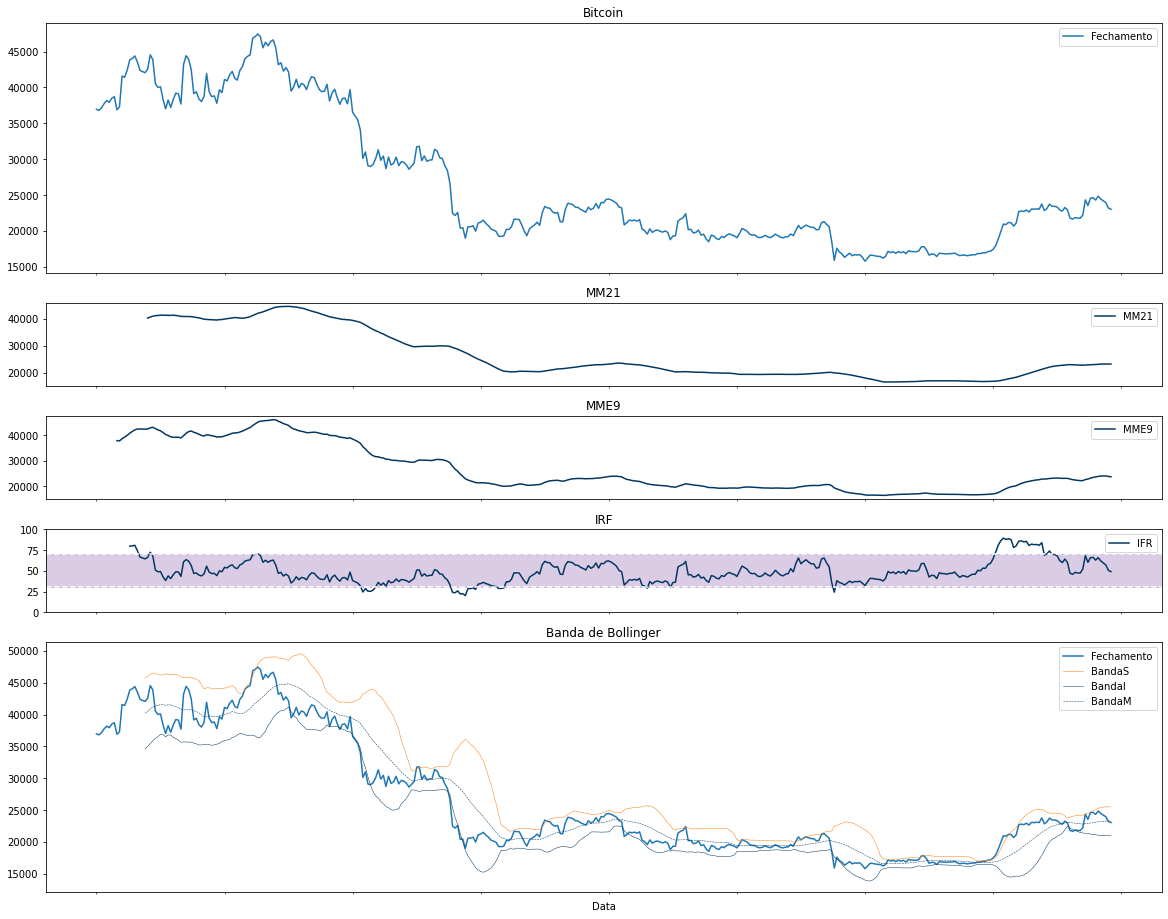

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(
    nrows=5,
    sharex=True,
    figsize=(20,16),
    gridspec_kw={'height_ratios': [3, 1, 1, 1, 3]})
#Preco
ax1.set_title("Bitcoin")
ax1.plot(dados.index, dados['Último'], label='Fechamento')
ax1.legend()
#MM21
ax2.set_title("MM21")
ax2.plot(dados.index, dados['MM21'], label='MM21', color="#033660")
ax2.legend()
#MME9
ax3.set_title("MME9")
ax3.plot(dados.index, dados['MME9'], label='MME9', color="#033660")
ax3.legend()
#IRF
ax4.set_title("IRF")
ax4.plot(dados.index, dados['I FRC'], label='IFR', color="#033660")
ax4.axhline(y=70, color='white', linestyle='--')
ax4.axhline(y=30, color='white', linestyle='--')
ax4.axhspan(30, 70, color='indigo', alpha=0.2)
ax4.set_ylim(0, 100)
ax4.legend()
#Banda
ax5.set_title("Banda de Bollinger")
dados['Último'].plot(ax=ax5, label='Fechamento')
dados['BandaS'].plot(ax=ax5, linewidth=0.5, label='BandaS')
dados['BandaI'].plot(ax=ax5, linewidth=0.5, color="#033660", label='BandaI')
dados['BandaM'].plot(ax=ax5, linewidth=0.5, color="#033660", linestyle="dashed", label='BandaM')
ax5.set_xticks([])
ax5.legend()

In [ ]:
#Mover Coluna outcome para o final da tabela
coluna = dados.pop('Outcome')
dados.insert(len(dados.columns), coluna.name, coluna)
dados

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Variacao,Ganho,Perda,FRS,FRC,I FRS,I FRC,MM21,MME9,DesvioP,BandaM,BandaS,BandaI,Outcome
Data,,,,,,,,,,,,,,,,,,,,
25.01.2022,36950.6,36691.3,37501.8,35729.3,79680.0,0.72,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
26.01.2022,36800.4,36962.3,38862.6,36280.0,107870.0,-0.41,-150.2,0.0,-150.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
27.01.2022,37164.3,36800.1,37215.4,35543.2,83520.0,0.99,363.9,363.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
28.01.2022,37745.1,37195.6,37995.9,36176.5,69450.0,1.56,580.8,580.8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
29.01.2022,38170.8,37736.5,38663.7,37350.2,42770.0,1.13,425.7,425.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21.02.2023,24450.7,24839.5,25236.8,24160.8,395970.0,-1.57,-388.8,0.0,-388.8,1.373578,1.629266,57.869520,61.966569,23215.857143,23984.860478,1088.070399,23190.370,25366.510798,21014.229202,0
22.02.2023,24186.6,24450.7,24474.3,23593.4,400240.0,-1.08,-264.1,0.0,-264.1,1.383493,1.463695,58.044766,59.410560,23237.809524,24025.208382,1109.799383,23228.320,25447.918767,21008.721233,0
23.02.2023,23936.3,24186.6,24590.4,23637.9,417460.0,-1.03,-250.3,0.0,-250.3,1.946615,1.326145,66.062758,57.010422,23262.033333,24007.426706,1120.356096,23253.575,25494.287191,21012.862809,0


In [ ]:
dados.isnull().sum()

Último       0
Abertura     0
Máxima       0
Mínima       0
Vol.         0
Var%         0
Variacao     1
Ganho        0
Perda        0
FRS         13
FRC         13
I FRS       13
I FRC       13
MM21        20
MME9         8
DesvioP     19
BandaM      19
BandaS      19
BandaI      19
Outcome      0
dtype: int64

<AxesSubplot:ylabel='Data'>

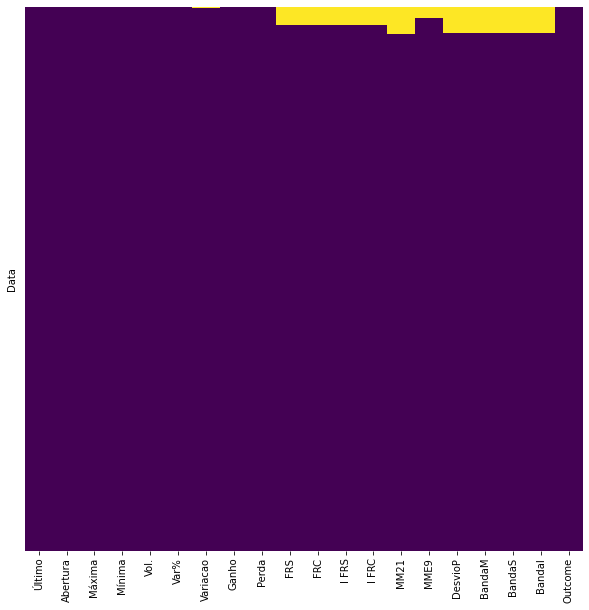

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(dados.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
dados = dados.dropna()

In [ ]:
dados.isnull().sum()

Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
Variacao    0
Ganho       0
Perda       0
FRS         0
FRC         0
I FRS       0
I FRC       0
MM21        0
MME9        0
DesvioP     0
BandaM      0
BandaS      0
BandaI      0
Outcome     0
dtype: int64

In [ ]:
#Dividir dados independentes
x_dados = dados.iloc[:, 0:19]
x_dados

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Variacao,Ganho,Perda,FRS,FRC,I FRS,I FRC,MM21,MME9,DesvioP,BandaM,BandaS,BandaI
Data,,,,,,,,,,,,,,,,,,,
14.02.2022,42550.3,42061.1,42799.7,41591.3,53600.0,1.16,489.2,489.2,0.0,1.941643,1.955893,66.005388,66.169275,40309.242857,42310.108727,2729.916815,40477.175,45937.008629,35017.341371
15.02.2022,44544.4,42550.3,44722.6,42460.1,56340.0,4.69,1994.1,1994.1,0.0,2.356024,2.614723,70.202835,72.335359,40670.852381,42760.288724,2730.159418,40864.375,46324.693835,35404.056165
16.02.2022,43883.6,44540.9,44552.9,43377.6,41400.0,-1.48,-660.8,0.0,-660.8,3.224293,2.116987,76.327400,67.917731,41008.147619,42986.285026,2663.489534,41200.340,46527.319068,35873.360932
17.02.2022,40552.8,43885.5,44167.1,40103.8,72630.0,-7.59,-3330.8,0.0,-3330.8,1.504255,1.041146,60.067963,51.007904,41169.504762,42497.278754,2543.058861,41340.725,46426.842723,36254.607277
18.02.2022,40000.1,40532.5,40935.5,39505.0,64960.0,-1.36,-552.7,0.0,-552.7,0.776951,0.954466,43.723824,48.835133,41276.885714,41995.949033,2454.398340,41432.190,46340.986680,36523.393320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21.02.2023,24450.7,24839.5,25236.8,24160.8,395970.0,-1.57,-388.8,0.0,-388.8,1.373578,1.629266,57.869520,61.966569,23215.857143,23984.860478,1088.070399,23190.370,25366.510798,21014.229202
22.02.2023,24186.6,24450.7,24474.3,23593.4,400240.0,-1.08,-264.1,0.0,-264.1,1.383493,1.463695,58.044766,59.410560,23237.809524,24025.208382,1109.799383,23228.320,25447.918767,21008.721233
23.02.2023,23936.3,24186.6,24590.4,23637.9,417460.0,-1.03,-250.3,0.0,-250.3,1.946615,1.326145,66.062758,57.010422,23262.033333,24007.426706,1120.356096,23253.575,25494.287191,21012.862809


In [ ]:
#Dividir dados dependentes
y_dados = dados.iloc[:, 19]
y_dados

Data
14.02.2022    1
15.02.2022    0
16.02.2022    0
17.02.2022    0
18.02.2022    1
             ..
21.02.2023    0
22.02.2023    0
23.02.2023    0
24.02.2023    0
25.02.2023    0
Name: Outcome, Length: 377, dtype: int64

In [ ]:
scaler_dados = StandardScaler()
x_dados = scaler_dados.fit_transform(x_dados)
x_dados

array([[ 1.88107547,  1.81301244,  1.78954989, ...,  1.56803078,
         1.61619177,  1.44699836],
       [ 2.10346318,  1.86733502,  1.9978535 , ...,  1.61036715,
         1.65320586,  1.49460635],
       [ 2.02976888,  2.08837863,  1.97947026, ...,  1.64710149,
         1.67255142,  1.55238189],
       ...,
       [-0.19481077, -0.17183834, -0.18302422, ..., -0.31519405,
        -0.33556883, -0.27707595],
       [-0.27787298, -0.19962148, -0.23361332, ..., -0.31591733,
        -0.33620916, -0.27787902],
       [-0.2974564 , -0.28236015, -0.33198583, ..., -0.31548052,
        -0.33602351, -0.27713477]])

In [ ]:
x_dados_treinamento, x_dados_teste, y_dados_treinamento, y_dados_teste = train_test_split(x_dados, y_dados, test_size = 0.2, random_state = 0)

In [ ]:
logmodel = LogisticRegression()
logmodel.fit(x_dados_treinamento,y_dados_treinamento)

LogisticRegression()

In [ ]:
predictions = logmodel.predict(x_dados_teste)

In [ ]:
print(classification_report(y_dados_teste,predictions))

              precision    recall  f1-score   support

           0       0.64      0.84      0.73        44
           1       0.61      0.34      0.44        32

    accuracy                           0.63        76
   macro avg       0.62      0.59      0.58        76
weighted avg       0.63      0.63      0.61        76



A Regressão Logistica atingiu 63% de precisâo, esse valor ocorre pois apesar de indicadores serem importantes para a previsão do valor, variaves sociais e politicas tem forte influencia no valor. Um codigo que considere, por exemplo, se as noticias sobre a moeda sao positivas ou negativas, pode obter um melhor resultado.


Outra Metodologia viavel é a regressão linear multipla.

In [ ]:
#Criar uma nova coluna com o valor futuro da moeda
dados['ValorFuturo'] = dados['Último'].shift(-1)

<ipython-input-32-9727360fd2d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados['ValorFuturo'] = dados['Último'].shift(-1)


In [ ]:
dados.isnull().sum()

Último         0
Abertura       0
Máxima         0
Mínima         0
Vol.           0
Var%           0
Variacao       0
Ganho          0
Perda          0
FRS            0
FRC            0
I FRS          0
I FRC          0
MM21           0
MME9           0
DesvioP        0
BandaM         0
BandaS         0
BandaI         0
Outcome        0
ValorFuturo    1
dtype: int64

In [ ]:
#A ultima linha nao tera valor futuro registrado então sera retirada
dados = dados.dropna()

In [ ]:
dados.isnull().sum()

Último         0
Abertura       0
Máxima         0
Mínima         0
Vol.           0
Var%           0
Variacao       0
Ganho          0
Perda          0
FRS            0
FRC            0
I FRS          0
I FRC          0
MM21           0
MME9           0
DesvioP        0
BandaM         0
BandaS         0
BandaI         0
Outcome        0
ValorFuturo    0
dtype: int64

In [ ]:
#Nao inclui a coluna
x_dados = dados.iloc[:, 0:19]
x_dados

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Variacao,Ganho,Perda,FRS,FRC,I FRS,I FRC,MM21,MME9,DesvioP,BandaM,BandaS,BandaI
Data,,,,,,,,,,,,,,,,,,,
14.02.2022,42550.3,42061.1,42799.7,41591.3,53600.0,1.16,489.2,489.2,0.0,1.941643,1.955893,66.005388,66.169275,40309.242857,42310.108727,2729.916815,40477.175,45937.008629,35017.341371
15.02.2022,44544.4,42550.3,44722.6,42460.1,56340.0,4.69,1994.1,1994.1,0.0,2.356024,2.614723,70.202835,72.335359,40670.852381,42760.288724,2730.159418,40864.375,46324.693835,35404.056165
16.02.2022,43883.6,44540.9,44552.9,43377.6,41400.0,-1.48,-660.8,0.0,-660.8,3.224293,2.116987,76.327400,67.917731,41008.147619,42986.285026,2663.489534,41200.340,46527.319068,35873.360932
17.02.2022,40552.8,43885.5,44167.1,40103.8,72630.0,-7.59,-3330.8,0.0,-3330.8,1.504255,1.041146,60.067963,51.007904,41169.504762,42497.278754,2543.058861,41340.725,46426.842723,36254.607277
18.02.2022,40000.1,40532.5,40935.5,39505.0,64960.0,-1.36,-552.7,0.0,-552.7,0.776951,0.954466,43.723824,48.835133,41276.885714,41995.949033,2454.398340,41432.190,46340.986680,36523.393320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20.02.2023,24839.5,24302.8,25085.4,23868.6,363020.0,2.21,536.6,536.6,0.0,1.736590,1.927292,63.458175,65.838729,23152.733333,23868.400597,1055.456938,23154.115,25265.028876,21043.201124
21.02.2023,24450.7,24839.5,25236.8,24160.8,395970.0,-1.57,-388.8,0.0,-388.8,1.373578,1.629266,57.869520,61.966569,23215.857143,23984.860478,1088.070399,23190.370,25366.510798,21014.229202
22.02.2023,24186.6,24450.7,24474.3,23593.4,400240.0,-1.08,-264.1,0.0,-264.1,1.383493,1.463695,58.044766,59.410560,23237.809524,24025.208382,1109.799383,23228.320,25447.918767,21008.721233


In [ ]:
#Agora a variavel dependente é coluna ValorFuturo, nao a outcome
y_dados = dados.iloc[:, 20]
y_dados

Data
14.02.2022    44544.4
15.02.2022    43883.6
16.02.2022    40552.8
17.02.2022    40000.1
18.02.2022    40090.3
               ...   
20.02.2023    24450.7
21.02.2023    24186.6
22.02.2023    23936.3
23.02.2023    23191.5
24.02.2023    23015.9
Name: ValorFuturo, Length: 376, dtype: float64

In [ ]:
scaler_dados = StandardScaler()
x_dados = scaler_dados.fit_transform(x_dados)
x_dados

array([[ 1.87800994,  1.81004827,  1.786555  , ...,  1.56531904,
         1.61339663,  1.44448944],
       [ 2.10012865,  1.86430451,  1.99461265, ...,  1.60760482,
         1.65036715,  1.49203911],
       [ 2.02652349,  2.08507817,  1.97625112, ...,  1.64429527,
         1.66968994,  1.54974386],
       ...,
       [-0.16748487, -0.1430877 , -0.19625203, ..., -0.31841353,
        -0.34048824, -0.2779819 ],
       [-0.19536527, -0.17237853, -0.18369002, ..., -0.31565545,
        -0.33606644, -0.27747266],
       [-0.27832701, -0.20012773, -0.23421939, ..., -0.31637787,
        -0.33670602, -0.27827474]])

In [ ]:
x_dados_treinamento, x_dados_teste, y_dados_treinamento, y_dados_teste = train_test_split(x_dados, y_dados, test_size = 0.2, random_state = 0)

In [ ]:
regressor_multiplo_dados = LinearRegression()
regressor_multiplo_dados.fit(x_dados_treinamento, y_dados_treinamento)

LinearRegression()

In [ ]:
regressor_multiplo_dados.intercept_

25653.957364182337

In [ ]:
regressor_multiplo_dados.coef_

array([-2.00300026e+05,  2.06488694e+05,  7.69254221e+02,  2.55475075e+03,
        6.30775398e+01,  2.62071010e+01,  9.51334921e+03,  7.04703666e+03,
        8.02292674e+03, -7.64332881e+00,  5.97126407e+00, -4.33888717e+01,
        1.64749970e+02,  2.54374787e+03, -4.31395455e+02, -6.13996383e+01,
       -6.29803756e+02, -5.61959331e+02, -6.93606941e+02])

In [ ]:
regressor_multiplo_dados.score(x_dados_treinamento, y_dados_treinamento)

0.9882762817801624

In [ ]:
regressor_multiplo_dados.score(x_dados_teste, y_dados_teste)

0.9932999863505191

In [ ]:
predictions = regressor_multiplo_dados.predict(x_dados_teste)
predictions

array([20598.77623768, 17244.03550261, 16893.98406665, 24426.89849336,
       18819.88910532, 28228.6290544 , 19223.6838994 , 21472.5143115 ,
       38007.8708655 , 42945.26418661, 17165.12094767, 22635.2640213 ,
       40490.15645123, 17043.7856943 , 23096.1574975 , 19154.58423504,
       42485.09422242, 23145.76493855, 23597.38385184, 16595.77024835,
       20751.74447265, 42543.47421193, 19179.43636537, 20204.9639956 ,
       16634.99231083, 37611.02304361, 19354.48686682, 20999.01389568,
       38170.12967706, 44204.77286175, 17141.44715253, 30005.5480131 ,
       41146.22697193, 19260.4161105 , 19566.57434497, 22408.64610987,
       21010.99221386, 21474.58345169, 38112.90904683, 38748.42227256,
       38399.12381994, 16743.27151252, 16816.41128861, 23133.98104226,
       45113.43974815, 44181.37899555, 16855.30375204, 24478.68862638,
       39796.62511283, 39309.93309494, 19773.01377831, 37016.34621401,
       19114.94896252, 24329.34138083, 39897.92197455, 18822.08615501,
      

In [ ]:
mae = mean_absolute_error(y_dados_teste, predictions)
mse = mean_squared_error(y_dados_teste, predictions)
rmse = np.sqrt(mse)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

MAE: 565.2741286475836
MSE: 621332.6615692234
RMSE: 788.2465740929189


In [ ]:
graph = regressor_multiplo_dados.predict(x_dados)
graph_series = pd.Series(graph)

[]

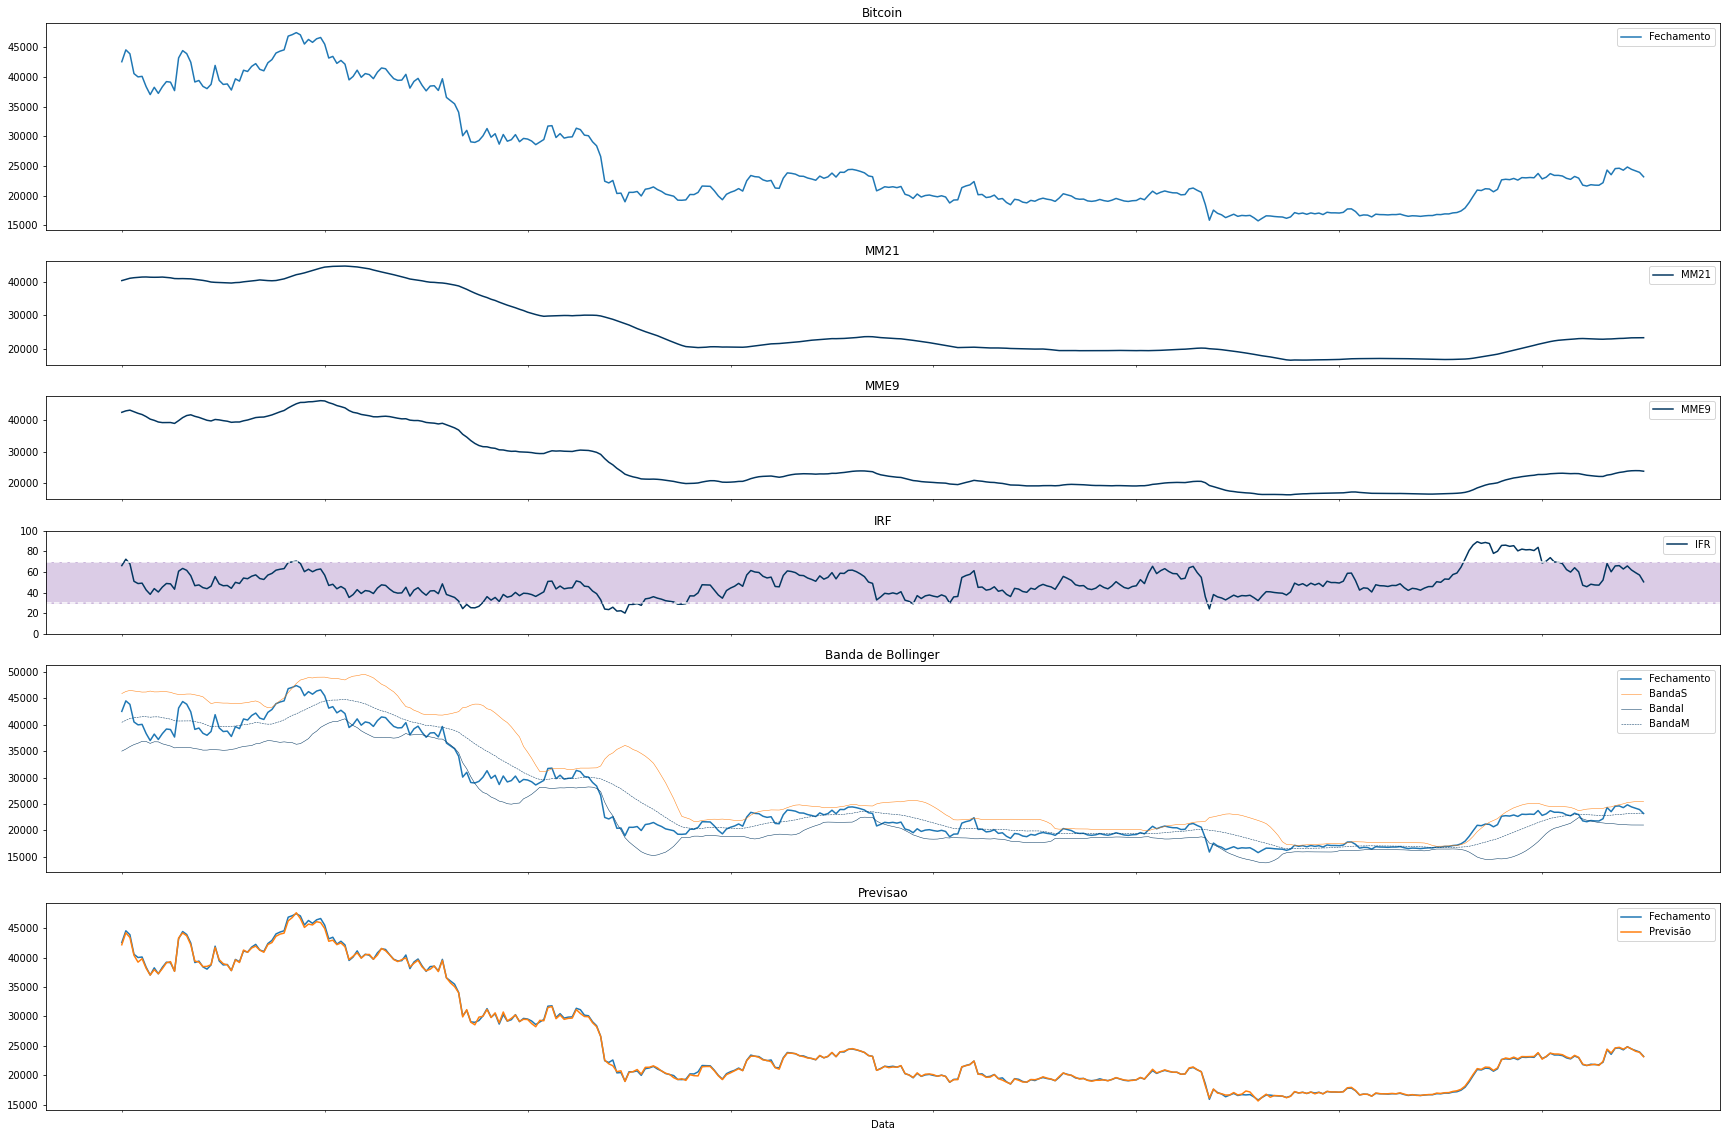

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(
    nrows=6,
    sharex=True,
    figsize=(30,20),
    gridspec_kw={'height_ratios': [2, 1, 1, 1, 2, 2]})
#Preco
ax1.set_title("Bitcoin")
ax1.plot(dados.index, dados['Último'], label='Fechamento')
ax1.legend()
#MM21
ax2.set_title("MM21")
ax2.plot(dados.index, dados['MM21'], label='MM21', color="#033660")
ax2.legend()
#MME9
ax3.set_title("MME9")
ax3.plot(dados.index, dados['MME9'], label='MME9', color="#033660")
ax3.legend()
#IRF
ax4.set_title("IRF")
ax4.plot(dados.index, dados['I FRC'], label='IFR', color="#033660")
ax4.axhline(y=70, color='white', linestyle='--')
ax4.axhline(y=30, color='white', linestyle='--')
ax4.axhspan(30, 70, color='indigo', alpha=0.2)
ax4.set_ylim(0, 100)
ax4.legend()
#Banda
ax5.set_title("Banda de Bollinger")
dados['Último'].plot(ax=ax5, label='Fechamento')
dados['BandaS'].plot(ax=ax5, linewidth=0.5, label='BandaS')
dados['BandaI'].plot(ax=ax5, linewidth=0.5, color="#033660", label='BandaI')
dados['BandaM'].plot(ax=ax5, linewidth=0.5, color="#033660", linestyle="dashed", label='BandaM')
ax5.legend()
#Previsão
ax6.set_title("Previsao")
dados['Último'].plot(ax=ax6, label='Fechamento')
graph_series.plot(ax=ax6, linewidth=1.5, label='Previsão')
ax6.legend()
ax6.set_xticks([])

O codigo de Regrassão linear multipla se adaptou bem com pontuação de 98%. Porem obteve um valor de erro muito alem do ideal.
Logo apesar de acompanhar bem a linha, não é tão preciso.